<a href="https://colab.research.google.com/github/sreent/dense-neural-networks/blob/main/codes/Rain%20in%20Australia%20-%20Mixed%20Feature%20Type%20%26%20Missing%20Value%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Defining the problem and assembling a dataset

- Kaggle Rain in Australia
  - https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
- Binary Classification Problem

 ## Choosing a measure of success

- Balanced Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [1]:
# mount gdrive, required for downloaded dataset
import os
from google.colab import drive
drive.mount("/content/drive")

!mkdir -p /content/drive/MyDrive/Neural\ Networks
!mkdir -p /content/drive/MyDrive/Neural\ Networks/Rain\ in\ Australia
!mkdir -p /content/drive/MyDrive/Neural\ Networks/Rain\ in\ Australia/data

# URL for our dataset, Tweets.csv
URL = "https://drive.google.com/file/d/1gt0c-jdMPYs_o7SBP67Al7Kg-5Ij3xY5/view?usp=sharing"
DOWNLOAD_FILE_PATH = "https://drive.google.com/uc?export=download&id=" + URL.split("/")[-2]

# install gdown, required for download file from GDrive
!pip -q install gdown==4.6.0
import gdown
gdown.download(DOWNLOAD_FILE_PATH, "/content/drive/MyDrive/Neural Networks/Rain in Australia/data/weatherAUS.csv", quiet=True)

Mounted at /content/drive


'/content/drive/MyDrive/Neural Networks/Rain in Australia/data/weatherAUS.csv'

In [21]:
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import F1Score, AUC

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

FILE_PATH = "/content/drive/MyDrive/Neural Networks/Rain in Australia/data/weatherAUS.csv"

In [4]:
weather = pd.read_csv(FILE_PATH)

weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
weather.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [6]:
NUMERICAL_VARIABLES = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
                       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

In [7]:
weather.drop(NUMERICAL_VARIABLES, axis=1).describe(include=object)

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2013-11-12,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


In [8]:
CATEGORICAL_VARIABLES = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [9]:
# Drop rows where target variables are missing or the locations are missing
weather = weather[~weather['RainTomorrow'].isnull() & ~weather['Location'].isnull()]

In [10]:
COLUMNS = CATEGORICAL_VARIABLES + NUMERICAL_VARIABLES

features = weather[COLUMNS]

TARGET_VARIABLE = 'RainTomorrow'
target = weather[TARGET_VARIABLE]

In [11]:
TEST_SIZE = 0.15

(XF_train, XF_test,
 yf_train, yf_test) = train_test_split(features,
                                       target,
                                       test_size=TEST_SIZE, stratify=target,
                                       shuffle=True, random_state=SEED)

In [12]:
# Imputing missing value for numerical features
knn_imp = KNNImputer(n_neighbors=5).fit(XF_train[NUMERICAL_VARIABLES])

NF_train = knn_imp.transform(XF_train[NUMERICAL_VARIABLES])
NF_test = knn_imp.transform(XF_test[NUMERICAL_VARIABLES])

In [13]:
CF_train = XF_train[CATEGORICAL_VARIABLES].fillna('Unknown')
CF_test = XF_test[CATEGORICAL_VARIABLES].fillna('Unknown')

In [14]:
XC_train = pd.DataFrame(data = np.hstack((NF_train, CF_train)),
                        columns = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES)

XC_test = pd.DataFrame(data = np.hstack((NF_test, CF_test)),
                        columns = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES)

In [15]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_VARIABLES),
    ('standard_scaler', StandardScaler(), NUMERICAL_VARIABLES)])

_ = preprocessor.fit(XC_train)

In [62]:
X_train, X_test = preprocessor.transform(XC_train), preprocessor.transform(XC_test)

In [63]:
label_encoder = LabelEncoder()
label_encoder.fit(yf_train)

y_train = label_encoder.transform(yf_train)
y_test = label_encoder.transform(yf_test)

In [64]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=VALIDATION_SIZE, stratify=y_train,
                                                  shuffle=True, random_state=SEED)

In [65]:
X_train, X_val, X_test = X_train.todense().astype(float), X_val.todense().astype(float), X_test.todense().astype(float)
y_train, y_val, y_test = y_train.astype(float), y_val.astype(float), y_test.astype(float)

##  Developing a model that does better than a baseline

In [66]:
counts = weather.groupby([TARGET_VARIABLE])[TARGET_VARIABLE].count()

counts

RainTomorrow
No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [67]:
naive_baseline = counts.iloc[0] / counts.sum()

naive_baseline

0.7758187815152645

In [68]:
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHT = dict(enumerate(weights))

CLASS_WEIGHT

{0: 0.6444814234469898, 1: 2.2303262525768575}

In [95]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           F1Score(name="f1_score", average='micro'),
           AUC(name="auc")]

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [106]:
baseline = Sequential(
    [
        Dense(OUTPUT_DIMENSION, activation='sigmoid', input_shape=(INPUT_DIMENSION,))
    ],
    name="baseline"
)

baseline.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1)                 120       
                                                                 
Total params: 120 (480.00 Byte)
Trainable params: 120 (480.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
batch_size = 512
EPOCHS = 100

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [108]:
learning_rate = 0.001

In [109]:
baseline.compile(optimizer=RMSprop(learning_rate=learning_rate),
                 loss=LOSS_FUNC, metrics=METRICS)

In [110]:
baseline_history = baseline.fit(X_train, y_train,
                                class_weight=CLASS_WEIGHT,
                                batch_size=batch_size, epochs=EPOCHS,
                                validation_data=(X_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

In [111]:
baseline_scores = baseline.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(baseline_scores[1]))
print('AUC (Validation): {:.2f}'.format(baseline_scores[2]))

Accuracy (Validation): 0.80 (Naive Baseline=0.78)
F1 Score (Validation): 0.37
AUC (Validation): 0.88


In [112]:
baseline_scores

[0.8015847206115723, 0.36621981859207153, 0.8780927658081055]

In [113]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

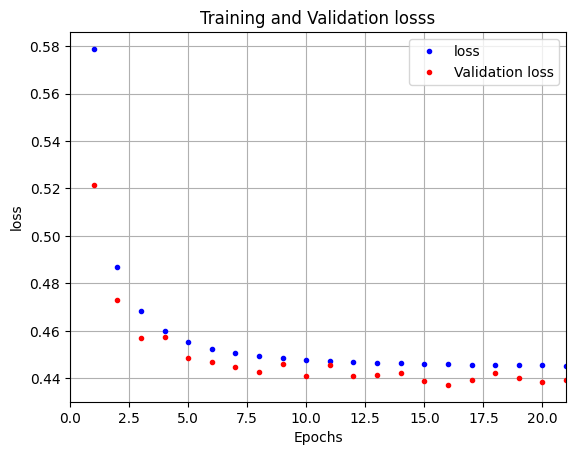

In [114]:
plot_training_history(baseline_history, monitor='loss')

 ## Scaling up: developing a model that overfits

In [115]:
overfit = Sequential(
    [
        Dense(64, activation="relu", input_shape=(INPUT_DIMENSION,), name="hidden"),
        Dense(OUTPUT_DIMENSION, activation="sigmoid", name="output")
    ],
    name="overfit"
)

overfit.summary()

Model: "overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 64)                7680      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 7745 (30.25 KB)
Trainable params: 7745 (30.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [116]:
learning_rate = 0.001

overfit.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=LOSS_FUNC, metrics=METRICS)

In [117]:
EPOCHS = 100
batch_size=512

overfit_history = overfit.fit(X_train, y_train,
                              class_weight=CLASS_WEIGHT,
                              batch_size=batch_size, epochs=EPOCHS,
                              validation_data=(X_val, y_val),
                              callbacks=[],
                              verbose=0)

In [118]:
overfit_scores = overfit.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(overfit_scores[1]))
print('AUC (Validation): {:.2f}'.format(overfit_scores[2]))

Accuracy (Validation): 0.82 (Naive Baseline = 0.78)
F1 Score (Validation): 0.37
AUC (Validation): 0.89


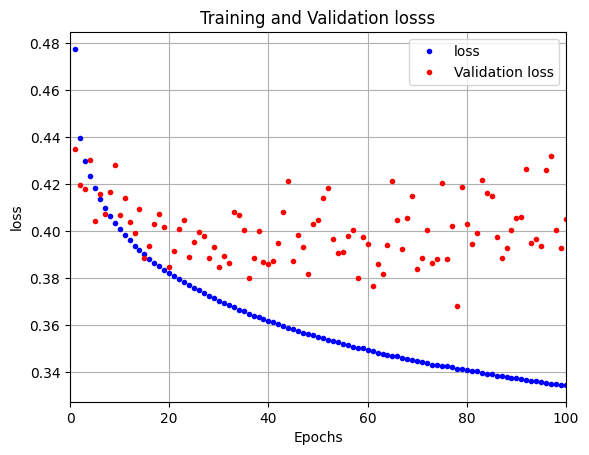

In [119]:
plot_training_history(overfit_history, monitor='loss')